# Challenge: Model Preparation

- This analysis takes the Life Expectancy dataset (https://www.kaggle.com/kumarajarshi/life-expectancy-who/home) and selects the best variables to serve as indicators for a Life Expectancy model. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import warnings
from scipy.stats import ttest_ind
from scipy.stats.mstats import winsorize
import math

warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'lifeexpectancy'
table_name = 'lifeexpectancy'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db, table_name))

life_df = pd.read_sql_query('select * from lifeexpectancy',con=engine)

# no need for an open connection, 
# as we're only doing a single query
engine.dispose()

In [3]:
life_df.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [4]:
life_df.nunique()

Country                             193
Year                                 16
Status                                2
Life expectancy                     362
Adult Mortality                     425
infant deaths                       209
Alcohol                            1076
percentage expenditure             2328
Hepatitis B                          87
Measles                             958
 BMI                                608
under-five deaths                   252
Polio                                73
Total expenditure                   818
Diphtheria                           81
 HIV/AIDS                           200
GDP                                2490
Population                         2278
 thinness  1-19 years               200
 thinness 5-9 years                 207
Income composition of resources     625
Schooling                           173
dtype: int64

In [5]:
life_df.columns

Index(['Country', 'Year', 'Status', 'Life expectancy ', 'Adult Mortality',
       'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B',
       'Measles ', ' BMI ', 'under-five deaths ', 'Polio', 'Total expenditure',
       'Diphtheria ', ' HIV/AIDS', 'GDP', 'Population',
       ' thinness  1-19 years', ' thinness 5-9 years',
       'Income composition of resources', 'Schooling'],
      dtype='object')

## Filling NA Values 
- We see numerous variable categories with NA value placeholders. Using the mean, median, interpolate, and dropna methods to populate these missing values, we look at which method preserves the original distribution's shape the best. 

In [6]:
life_df.isnull().sum()*100/life_df.isnull().count()

Country                             0.000000
Year                                0.000000
Status                              0.000000
Life expectancy                     0.340368
Adult Mortality                     0.340368
infant deaths                       0.000000
Alcohol                             6.603131
percentage expenditure              0.000000
Hepatitis B                        18.822328
Measles                             0.000000
 BMI                                1.157250
under-five deaths                   0.000000
Polio                               0.646698
Total expenditure                   7.692308
Diphtheria                          0.646698
 HIV/AIDS                           0.000000
GDP                                15.248468
Population                         22.191967
 thinness  1-19 years               1.157250
 thinness 5-9 years                 1.157250
Income composition of resources     5.684139
Schooling                           5.547992
dtype: flo

### Fill NA with mean value.

In [7]:
life_mean_df = life_df.copy()

fill_list = ["Life expectancy ", "Adult Mortality", "infant deaths", "Alcohol", 
             "percentage expenditure", "Hepatitis B",
             "Measles ", " BMI ", "under-five deaths ", 
             "Polio", "Total expenditure", "Diphtheria ","GDP","Population"," thinness  1-19 years", " thinness 5-9 years", 
             "Income composition of resources", "Schooling"]

for col in fill_list:
    life_mean_df.loc[:, col].fillna(life_mean_df.loc[:, col].mean(), inplace=True)
    

In [8]:
life_mean_df.isnull().sum()*100/life_mean_df.isnull().count()

Country                            0.0
Year                               0.0
Status                             0.0
Life expectancy                    0.0
Adult Mortality                    0.0
infant deaths                      0.0
Alcohol                            0.0
percentage expenditure             0.0
Hepatitis B                        0.0
Measles                            0.0
 BMI                               0.0
under-five deaths                  0.0
Polio                              0.0
Total expenditure                  0.0
Diphtheria                         0.0
 HIV/AIDS                          0.0
GDP                                0.0
Population                         0.0
 thinness  1-19 years              0.0
 thinness 5-9 years                0.0
Income composition of resources    0.0
Schooling                          0.0
dtype: float64

### Fill NA with median value.

In [9]:
life_median_df = life_df.copy()

for col in fill_list:
    life_median_df.loc[:, col].fillna(life_median_df.loc[:, col].median(), inplace=True)

In [10]:
life_median_df.isnull().sum()*100/life_median_df.isnull().count()

Country                            0.0
Year                               0.0
Status                             0.0
Life expectancy                    0.0
Adult Mortality                    0.0
infant deaths                      0.0
Alcohol                            0.0
percentage expenditure             0.0
Hepatitis B                        0.0
Measles                            0.0
 BMI                               0.0
under-five deaths                  0.0
Polio                              0.0
Total expenditure                  0.0
Diphtheria                         0.0
 HIV/AIDS                          0.0
GDP                                0.0
Population                         0.0
 thinness  1-19 years              0.0
 thinness 5-9 years                0.0
Income composition of resources    0.0
Schooling                          0.0
dtype: float64

### Fill NA with interpolated value.

In [11]:
life_interp_df = life_df.copy()

for col in fill_list:
    life_interp_df.loc[:, col].interpolate(inplace=True)

In [12]:
life_interp_df.isnull().sum()*100/life_interp_df.isnull().count()

Country                            0.0
Year                               0.0
Status                             0.0
Life expectancy                    0.0
Adult Mortality                    0.0
infant deaths                      0.0
Alcohol                            0.0
percentage expenditure             0.0
Hepatitis B                        0.0
Measles                            0.0
 BMI                               0.0
under-five deaths                  0.0
Polio                              0.0
Total expenditure                  0.0
Diphtheria                         0.0
 HIV/AIDS                          0.0
GDP                                0.0
Population                         0.0
 thinness  1-19 years              0.0
 thinness 5-9 years                0.0
Income composition of resources    0.0
Schooling                          0.0
dtype: float64

### Compare dropna, mean, median, interpolate NA method effects on distribution shape

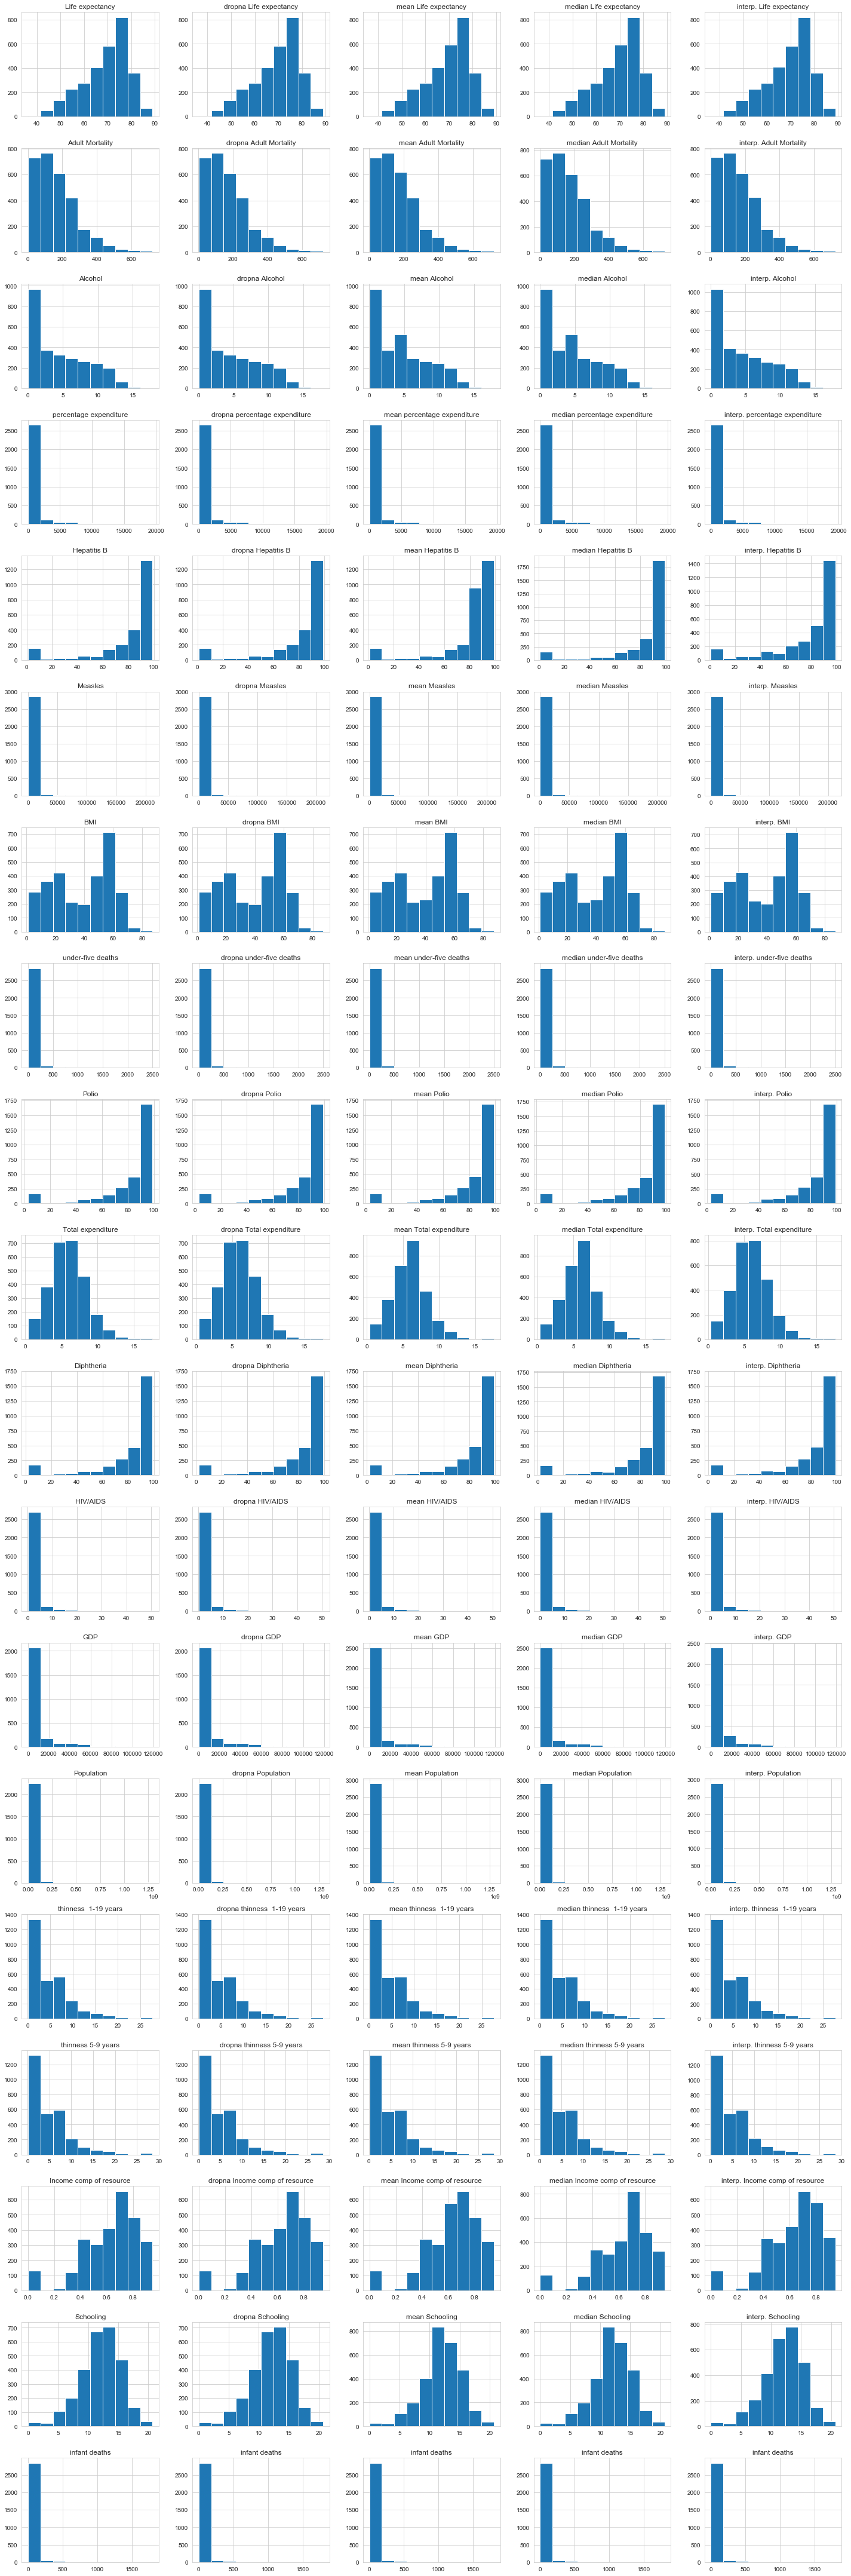

In [13]:
plt.figure(figsize=(20,60))

#original

plt.subplot(19,5,1)
plt.hist(life_df["Life expectancy "])
plt.title("Life expectancy")

plt.subplot(19,5,6)
plt.hist(life_df["Adult Mortality"])
plt.title("Adult Mortality")

plt.subplot(19,5,11)
plt.hist(life_df["Alcohol"])
plt.title("Alcohol")

plt.subplot(19,5,16)
plt.hist(life_df["percentage expenditure"])
plt.title("percentage expenditure")

plt.subplot(19,5,21)
plt.hist(life_df["Hepatitis B"])
plt.title("Hepatitis B")

plt.subplot(19,5,26)
plt.hist(life_df["Measles "])
plt.title("Measles")

plt.subplot(19,5,31)
plt.hist(life_df[" BMI "])
plt.title("BMI")

plt.subplot(19,5,36)
plt.hist(life_df["under-five deaths "])
plt.title("under-five deaths")

plt.subplot(19,5,41)
plt.hist(life_df["Polio"])
plt.title("Polio")

plt.subplot(19,5,46)
plt.hist(life_df["Total expenditure"])
plt.title("Total expenditure")

plt.subplot(19,5,51)
plt.hist(life_df["Diphtheria "])
plt.title("Diphtheria")

plt.subplot(19,5,56)
plt.hist(life_df[" HIV/AIDS"])
plt.title("HIV/AIDS")

plt.subplot(19,5,61)
plt.hist(life_df["GDP"])
plt.title("GDP")

plt.subplot(19,5,66)
plt.hist(life_df["Population"])
plt.title("Population")

plt.subplot(19,5,71)
plt.hist(life_df[" thinness  1-19 years"])
plt.title("thinness  1-19 years")

plt.subplot(19,5,76)
plt.hist(life_df[" thinness 5-9 years"])
plt.title("thinness 5-9 years")

plt.subplot(19,5,81)
plt.hist(life_df["Income composition of resources"])
plt.title("Income comp of resource")

plt.subplot(19,5,86)
plt.hist(life_df["Schooling"])
plt.title("Schooling")

plt.subplot(19,5,91)
plt.hist(life_df["infant deaths"])
plt.title("infant deaths")

#dropna

plt.subplot(19,5,2)
plt.hist(life_df["Life expectancy "].dropna())
plt.title("dropna Life expectancy")

plt.subplot(19,5,7)
plt.hist(life_df["Adult Mortality"].dropna())
plt.title("dropna Adult Mortality")

plt.subplot(19,5,12)
plt.hist(life_df["Alcohol"].dropna())
plt.title("dropna Alcohol")

plt.subplot(19,5,17)
plt.hist(life_df["percentage expenditure"].dropna())
plt.title("dropna percentage expenditure")

plt.subplot(19,5,22)
plt.hist(life_df["Hepatitis B"].dropna())
plt.title("dropna Hepatitis B")

plt.subplot(19,5,27)
plt.hist(life_df["Measles "].dropna())
plt.title("dropna Measles")

plt.subplot(19,5,32)
plt.hist(life_df[" BMI "].dropna())
plt.title("dropna BMI")

plt.subplot(19,5,37)
plt.hist(life_df["under-five deaths "].dropna())
plt.title("dropna under-five deaths")

plt.subplot(19,5,42)
plt.hist(life_df["Polio"].dropna())
plt.title("dropna Polio")

plt.subplot(19,5,47)
plt.hist(life_df["Total expenditure"].dropna())
plt.title("dropna Total expenditure")

plt.subplot(19,5,52)
plt.hist(life_df["Diphtheria "].dropna())
plt.title("dropna Diphtheria")

plt.subplot(19,5,57)
plt.hist(life_df[" HIV/AIDS"].dropna())
plt.title("dropna HIV/AIDS")

plt.subplot(19,5,62)
plt.hist(life_df["GDP"].dropna())
plt.title("dropna GDP")

plt.subplot(19,5,67)
plt.hist(life_df["Population"].dropna())
plt.title("dropna Population")

plt.subplot(19,5,72)
plt.hist(life_df[" thinness  1-19 years"].dropna())
plt.title("dropna thinness  1-19 years")

plt.subplot(19,5,77)
plt.hist(life_df[" thinness 5-9 years"].dropna())
plt.title("dropna thinness 5-9 years")

plt.subplot(19,5,82)
plt.hist(life_df["Income composition of resources"].dropna())
plt.title("dropna Income comp of resource")

plt.subplot(19,5,87)
plt.hist(life_df["Schooling"].dropna())
plt.title("dropna Schooling")

plt.subplot(19,5,92)
plt.hist(life_df["infant deaths"].dropna())
plt.title("infant deaths")


#mean

plt.subplot(19,5,3)
plt.hist(life_mean_df["Life expectancy "])
plt.title("mean Life expectancy")

plt.subplot(19,5,8)
plt.hist(life_mean_df["Adult Mortality"])
plt.title("mean Adult Mortality")

plt.subplot(19,5,13)
plt.hist(life_mean_df["Alcohol"])
plt.title("mean Alcohol")

plt.subplot(19,5,18)
plt.hist(life_mean_df["percentage expenditure"])
plt.title("mean percentage expenditure")

plt.subplot(19,5,23)
plt.hist(life_mean_df["Hepatitis B"])
plt.title("mean Hepatitis B")

plt.subplot(19,5,28)
plt.hist(life_mean_df["Measles "])
plt.title("mean Measles")

plt.subplot(19,5,33)
plt.hist(life_mean_df[" BMI "])
plt.title("mean BMI")

plt.subplot(19,5,38)
plt.hist(life_mean_df["under-five deaths "])
plt.title("mean under-five deaths")

plt.subplot(19,5,43)
plt.hist(life_mean_df["Polio"])
plt.title("mean Polio")

plt.subplot(19,5,48)
plt.hist(life_mean_df["Total expenditure"])
plt.title("mean Total expenditure")

plt.subplot(19,5,53)
plt.hist(life_mean_df["Diphtheria "])
plt.title("mean Diphtheria")

plt.subplot(19,5,58)
plt.hist(life_mean_df[" HIV/AIDS"])
plt.title("mean HIV/AIDS")

plt.subplot(19,5,63)
plt.hist(life_mean_df["GDP"])
plt.title("mean GDP")

plt.subplot(19,5,68)
plt.hist(life_mean_df["Population"])
plt.title("mean Population")

plt.subplot(19,5,73)
plt.hist(life_mean_df[" thinness  1-19 years"])
plt.title("mean thinness  1-19 years")

plt.subplot(19,5,78)
plt.hist(life_mean_df[" thinness 5-9 years"])
plt.title("mean thinness 5-9 years")

plt.subplot(19,5,83)
plt.hist(life_mean_df["Income composition of resources"])
plt.title("mean Income comp of resource")

plt.subplot(19,5,88)
plt.hist(life_mean_df["Schooling"])
plt.title("mean Schooling")

plt.subplot(19,5,93)
plt.hist(life_mean_df["infant deaths"])
plt.title("infant deaths")


#median

plt.subplot(19,5,4)
plt.hist(life_median_df["Life expectancy "])
plt.title("median Life expectancy")

plt.subplot(19,5,9)
plt.hist(life_median_df["Adult Mortality"])
plt.title("median Adult Mortality")

plt.subplot(19,5,14)
plt.hist(life_median_df["Alcohol"])
plt.title("median Alcohol")

plt.subplot(19,5,19)
plt.hist(life_median_df["percentage expenditure"])
plt.title("median percentage expenditure")

plt.subplot(19,5,24)
plt.hist(life_median_df["Hepatitis B"])
plt.title("median Hepatitis B")

plt.subplot(19,5,29)
plt.hist(life_median_df["Measles "])
plt.title("median Measles")

plt.subplot(19,5,34)
plt.hist(life_median_df[" BMI "])
plt.title("median BMI")

plt.subplot(19,5,39)
plt.hist(life_median_df["under-five deaths "])
plt.title("median under-five deaths")

plt.subplot(19,5,44)
plt.hist(life_median_df["Polio"])
plt.title("median Polio")

plt.subplot(19,5,49)
plt.hist(life_median_df["Total expenditure"])
plt.title("median Total expenditure")

plt.subplot(19,5,54)
plt.hist(life_median_df["Diphtheria "])
plt.title("median Diphtheria")

plt.subplot(19,5,59)
plt.hist(life_median_df[" HIV/AIDS"])
plt.title("median HIV/AIDS")

plt.subplot(19,5,64)
plt.hist(life_median_df["GDP"])
plt.title("median GDP")

plt.subplot(19,5,69)
plt.hist(life_median_df["Population"])
plt.title("median Population")

plt.subplot(19,5,74)
plt.hist(life_median_df[" thinness  1-19 years"])
plt.title("median thinness  1-19 years")

plt.subplot(19,5,79)
plt.hist(life_median_df[" thinness 5-9 years"])
plt.title("median thinness 5-9 years")

plt.subplot(19,5,84)
plt.hist(life_median_df["Income composition of resources"])
plt.title("median Income comp of resource")

plt.subplot(19,5,89)
plt.hist(life_median_df["Schooling"])
plt.title("median Schooling")

plt.subplot(19,5,94)
plt.hist(life_median_df["infant deaths"])
plt.title("infant deaths")

#interpolate

plt.subplot(19,5,5)
plt.hist(life_interp_df["Life expectancy "])
plt.title("interp. Life expectancy")

plt.subplot(19,5,10)
plt.hist(life_interp_df["Adult Mortality"])
plt.title("interp. Adult Mortality")

plt.subplot(19,5,15)
plt.hist(life_interp_df["Alcohol"])
plt.title("interp. Alcohol")

plt.subplot(19,5,20)
plt.hist(life_interp_df["percentage expenditure"])
plt.title("interp. percentage expenditure")

plt.subplot(19,5,25)
plt.hist(life_interp_df["Hepatitis B"])
plt.title("interp. Hepatitis B")

plt.subplot(19,5,30)
plt.hist(life_interp_df["Measles "])
plt.title("interp. Measles")

plt.subplot(19,5,35)
plt.hist(life_interp_df[" BMI "])
plt.title("interp. BMI")

plt.subplot(19,5,40)
plt.hist(life_interp_df["under-five deaths "])
plt.title("interp. under-five deaths")

plt.subplot(19,5,45)
plt.hist(life_interp_df["Polio"])
plt.title("interp. Polio")

plt.subplot(19,5,50)
plt.hist(life_interp_df["Total expenditure"])
plt.title("interp. Total expenditure")

plt.subplot(19,5,55)
plt.hist(life_interp_df["Diphtheria "])
plt.title("interp. Diphtheria")

plt.subplot(19,5,60)
plt.hist(life_interp_df[" HIV/AIDS"])
plt.title("interp. HIV/AIDS")

plt.subplot(19,5,65)
plt.hist(life_interp_df["GDP"])
plt.title("interp. GDP")

plt.subplot(19,5,70)
plt.hist(life_interp_df["Population"])
plt.title("interp. Population")

plt.subplot(19,5,75)
plt.hist(life_interp_df[" thinness  1-19 years"])
plt.title("interp. thinness  1-19 years")

plt.subplot(19,5,80)
plt.hist(life_interp_df[" thinness 5-9 years"])
plt.title("interp. thinness 5-9 years")

plt.subplot(19,5,85)
plt.hist(life_interp_df["Income composition of resources"])
plt.title("interp. Income comp of resource")

plt.subplot(19,5,90)
plt.hist(life_interp_df["Schooling"])
plt.title("interp. Schooling")

plt.subplot(19,5,95)
plt.hist(life_interp_df["infant deaths"])
plt.title("infant deaths")


plt.tight_layout()
plt.show()

- The mean and median fill methods have the most agressive affect on the distribution's shape, while we see that the dropna and interpolate techniques resemble the original dat much more closely. Since the dropna method removes entire row of data, lets compare how much information is lost in this way. 

In [14]:
print("Remaing total columns from Dropna method: {}".format(len(life_df.dropna())))
print("Remaing total columns from Interpolate method: {}".format(len(life_interp_df)))

Remaing total columns from Dropna method: 1649
Remaing total columns from Interpolate method: 2938


- The dropna method is shown to cut amlost half of our data. Because of this, the interpolate method is chosen as a better population technique. 

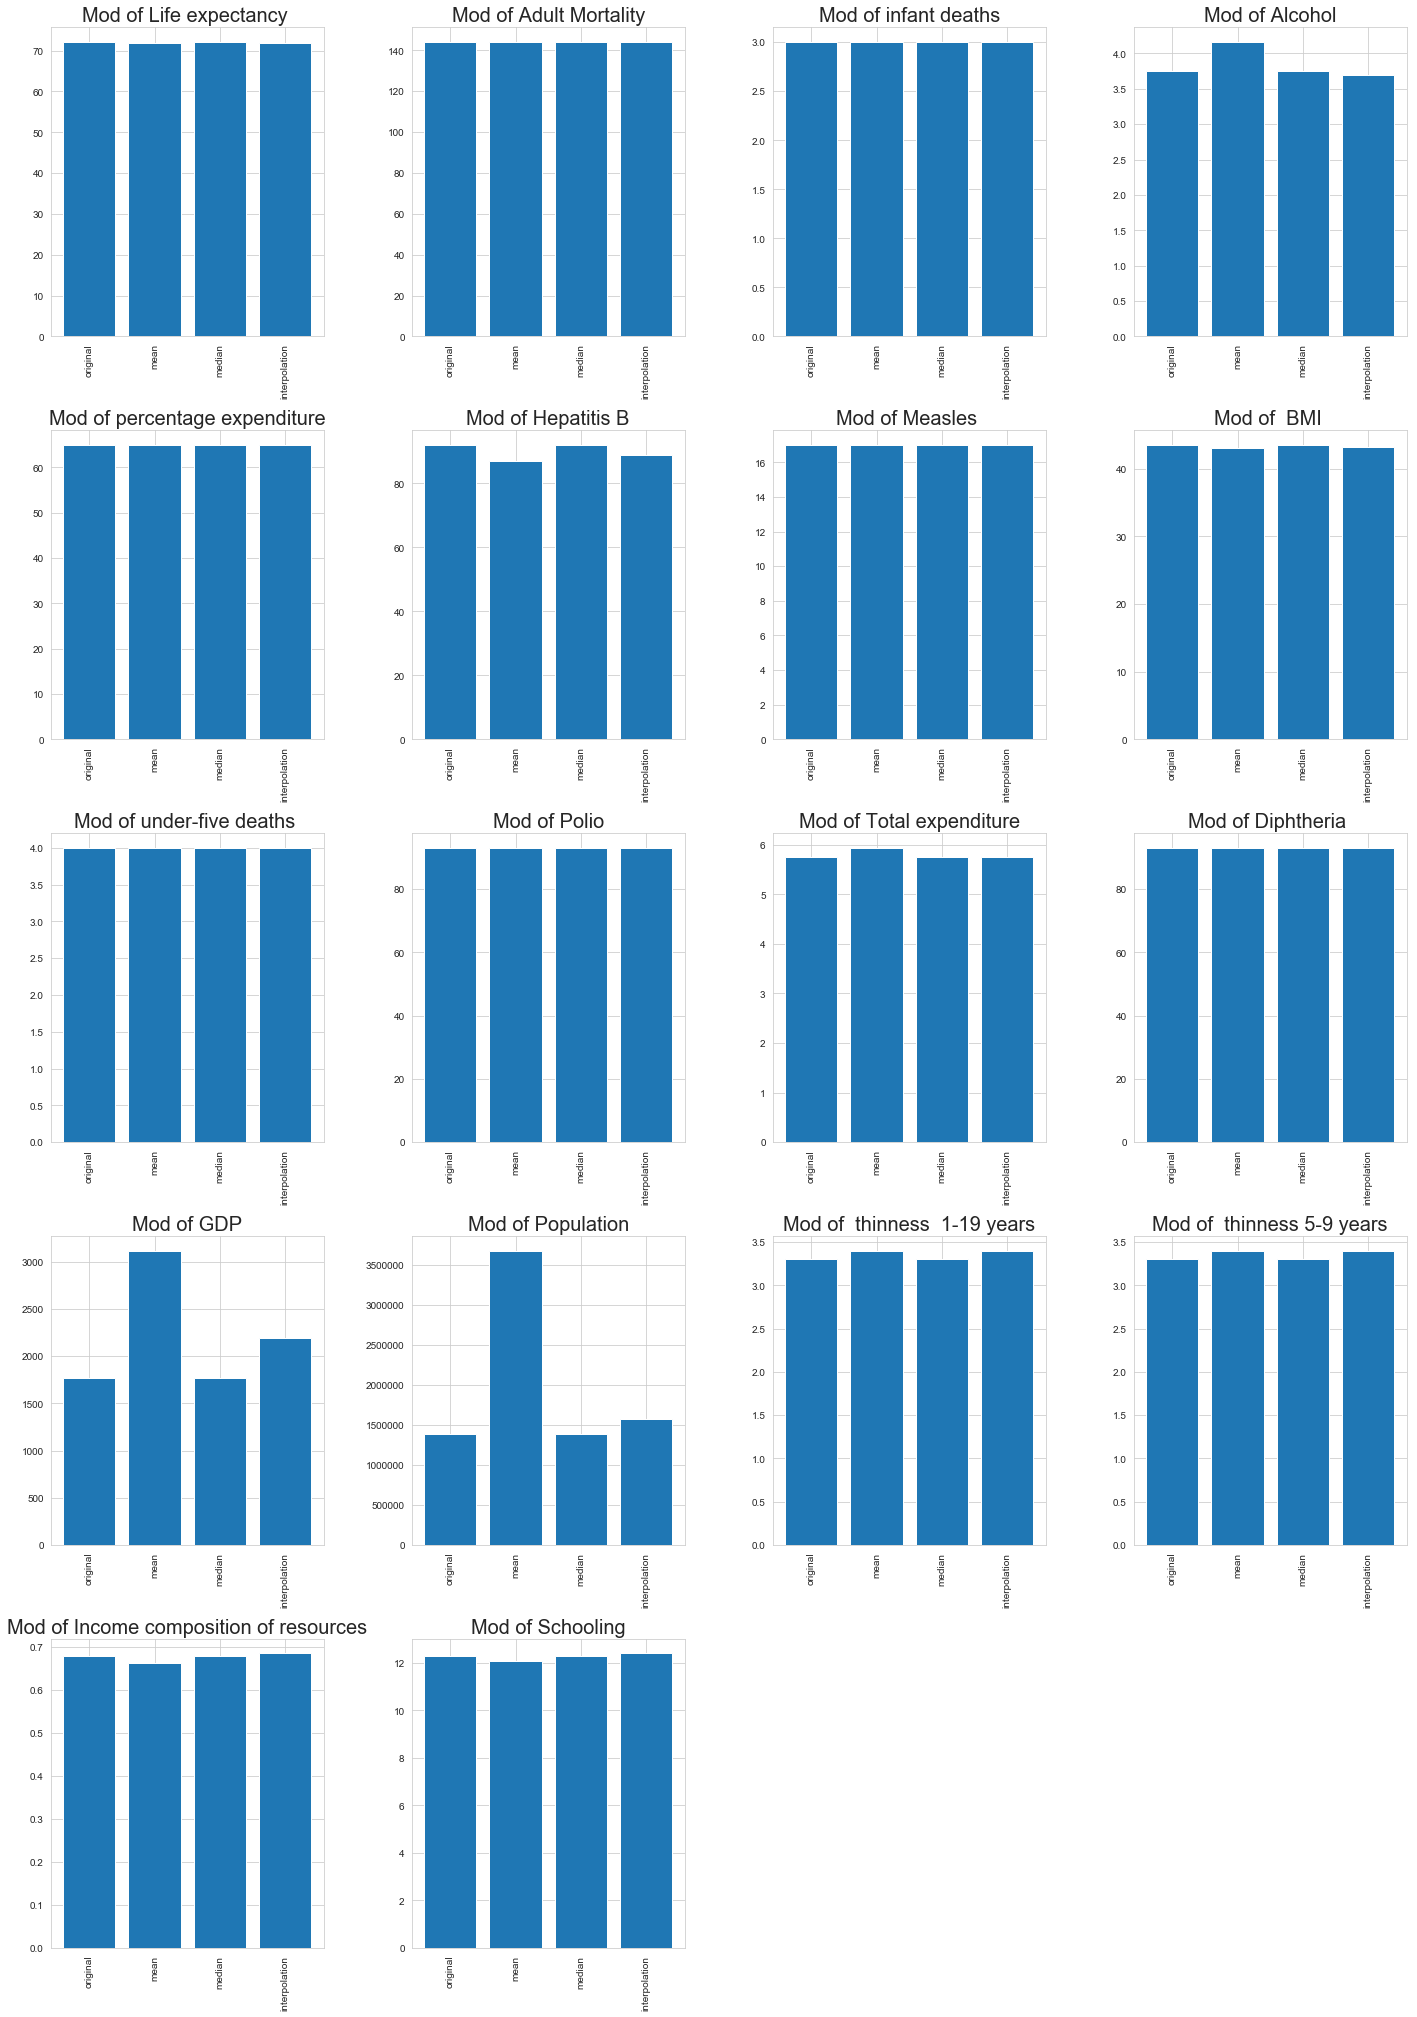

In [15]:
fig = plt.figure(figsize=(20,100))

for i, col in enumerate(fill_list):
    df = pd.concat([life_df[col], life_mean_df[col],
                     life_median_df[col], life_interp_df[col]], axis=1)
    
    plt.subplot(len(fill_list), 4, i+1)
    plt.bar(["original", "mean", "median", "interpolation"], df.median())
    plt.xticks(rotation='vertical')
    plt.title("Mod of {}".format(col),fontsize=20)
    
plt.tight_layout()
plt.show()

- We see that the mean value method pulls the distribution's median much higher than the other techniques, this indicates the presence of outliers in the dataset. 

## Outlier Detection/Removal

- Using boxpolts, we get a general picture of the magnitude od outliers present in each variable category.

<Figure size 432x288 with 0 Axes>

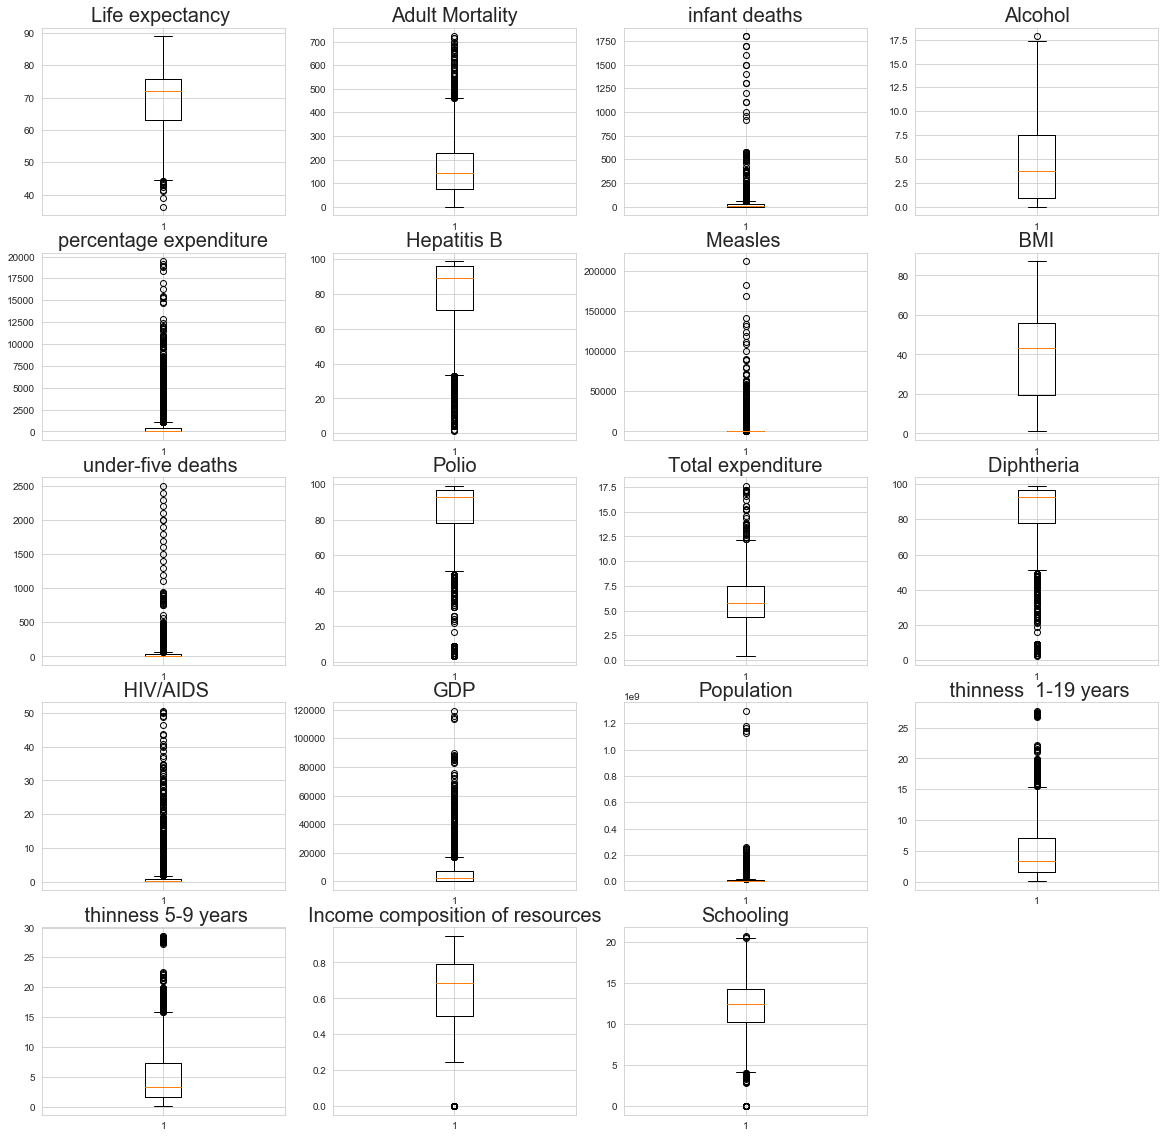

In [25]:
life_interp_int_df = life_interp_df.select_dtypes(include=['float64','int'])

def get_boxplot(df):
    ceil = math.ceil(math.sqrt(len(df.columns)))
    flr = math.floor(math.sqrt(len(df.columns)))
    plt.figure(figsize=(ceil*flr,ceil*flr))
    i = 1
    #print(df.columns)
    for column in df.columns[1:]: #removes "Year" column 
        plt.subplot(ceil,flr,i)
        plt.boxplot(df[column])
        plt.title(df[column].name,fontsize=20)
        i+=1
plt.tight_layout()
plt.show() 

get_boxplot(life_interp_int_df)

- From the boxplot analysis we see many outliers present in multiple variable categories. The Winsor method will be used to handle the outliers present in each variable. 

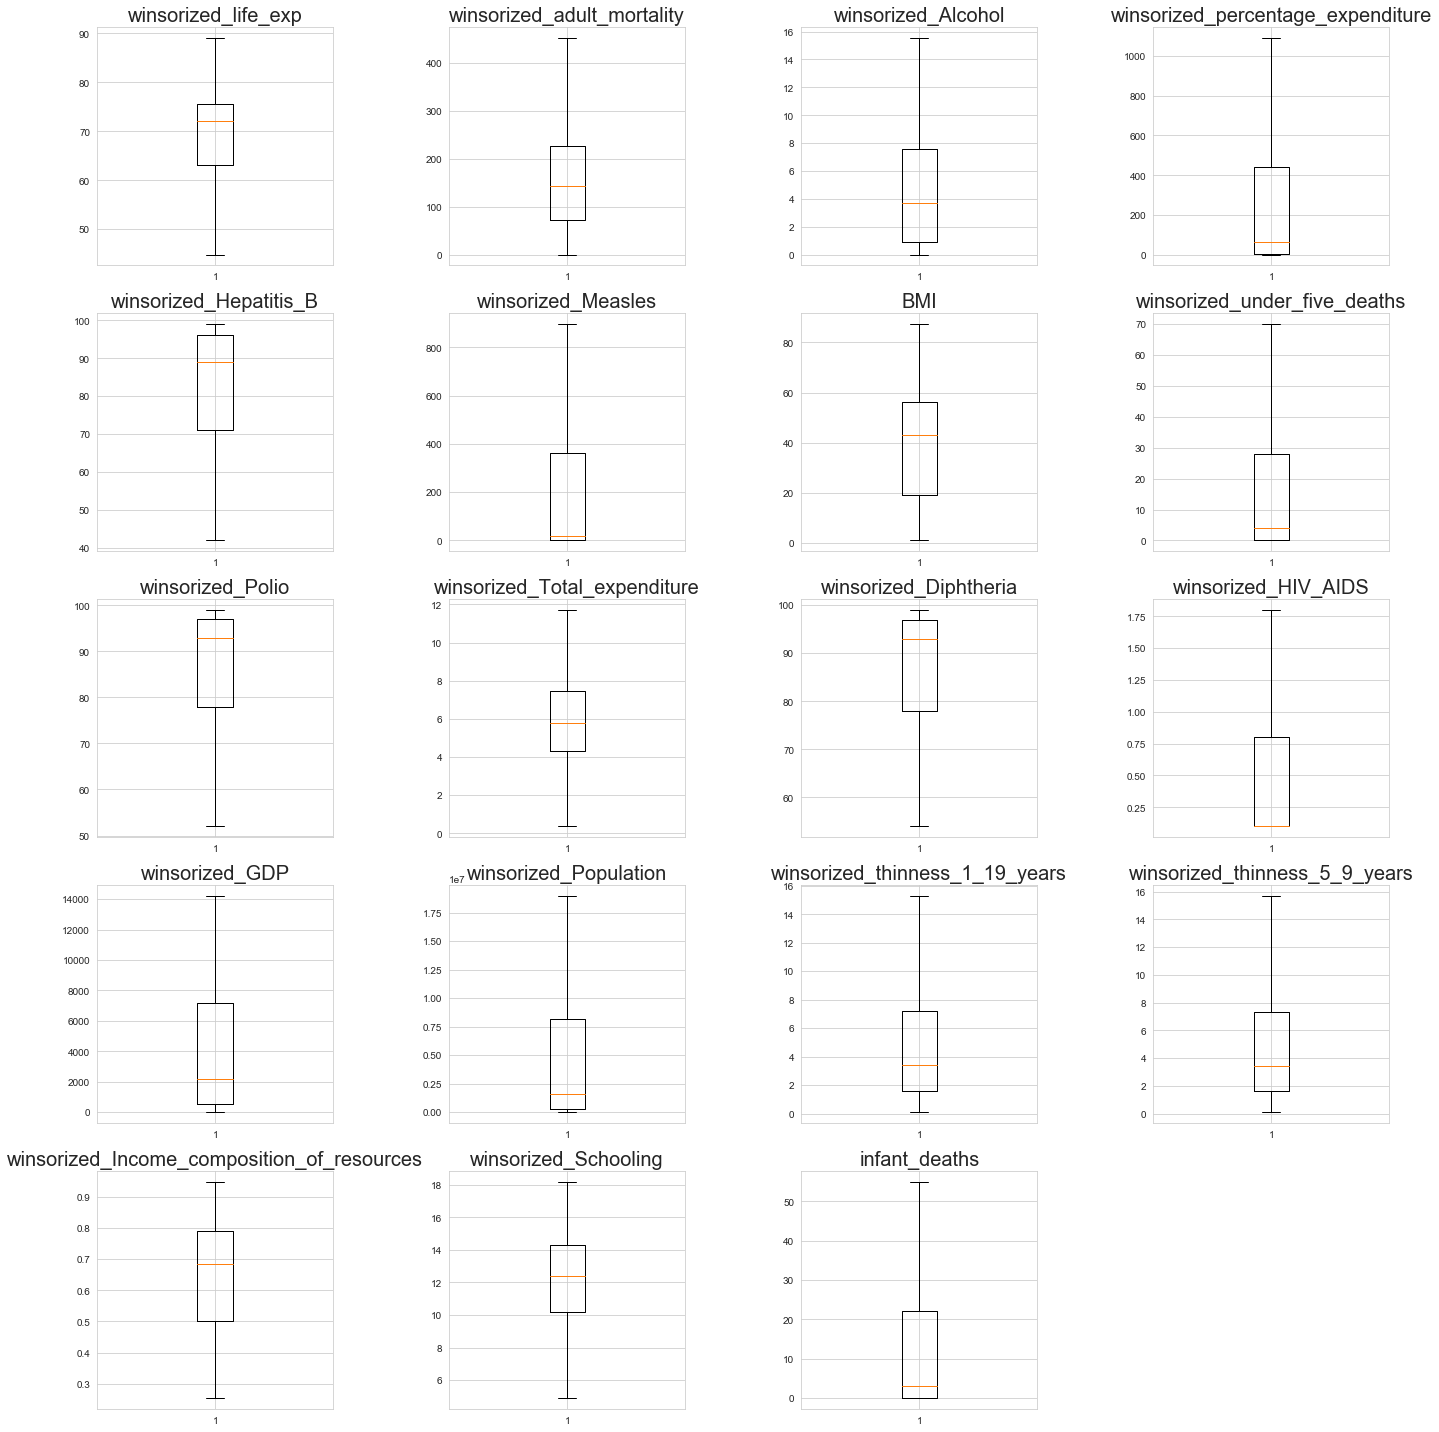

In [27]:
plt.figure(figsize=(20,20))

plt.subplot(5,4,1)
winsorized_life_exp = winsorize(life_interp_df["Life expectancy "], (0.006, 0))
plt.boxplot(winsorized_life_exp)
plt.title("winsorized_life_exp",fontsize=20)

plt.subplot(5,4,2)
winsorized_adult_mortality = winsorize(life_interp_df["Adult Mortality"], (0, 0.03))
plt.boxplot(winsorized_adult_mortality)
plt.title("winsorized_adult_mortality",fontsize=20)

plt.subplot(5,4,3)
winsorized_Alcohol = winsorize(life_interp_df["Alcohol"], (0, 0.002))
plt.boxplot(winsorized_Alcohol)
plt.title("winsorized_Alcohol",fontsize=20)

plt.subplot(5,4,4)
winsorized_percentage_expenditure = winsorize(life_interp_df["percentage expenditure"], (0, 0.133))
plt.boxplot(winsorized_percentage_expenditure)
plt.title("winsorized_percentage_expenditure",fontsize=20)

plt.subplot(5,4,5)
winsorized_Hepatitis_B = winsorize(life_interp_df["Hepatitis B"], (0.11, 0))
plt.boxplot(winsorized_Hepatitis_B)
plt.title("winsorized_Hepatitis_B",fontsize=20)

plt.subplot(5,4,6)
winsorized_Measles = winsorize(life_interp_df["Measles "], (0, 0.185))
plt.boxplot(winsorized_Measles)
plt.title("winsorized_Measles",fontsize=20)

plt.subplot(5,4,7)
plt.boxplot(life_interp_df[" BMI "])
plt.title("BMI",fontsize=20)

plt.subplot(5,4,8)
winsorized_under_five_deaths = winsorize(life_interp_df["under-five deaths "], (0, 0.135))
plt.boxplot(winsorized_under_five_deaths)
plt.title("winsorized_under_five_deaths",fontsize=20)

plt.subplot(5,4,9)
winsorized_Polio = winsorize(life_interp_df["Polio"], (0.1, 0))
plt.boxplot(winsorized_Polio)
plt.title("winsorized_Polio",fontsize=20)

plt.subplot(5,4,10)
winsorized_Total_expenditure = winsorize(life_interp_df["Total expenditure"], (0, 0.018))
plt.boxplot(winsorized_Total_expenditure)
plt.title("winsorized_Total_expenditure",fontsize=20)

plt.subplot(5,4,11)
winsorized_Diphtheria = winsorize(life_interp_df["Diphtheria "], (0.11, 0))
plt.boxplot(winsorized_Diphtheria)
plt.title("winsorized_Diphtheria",fontsize=20)

plt.subplot(5,4,12)
winsorized_HIV_AIDS = winsorize(life_interp_df[" HIV/AIDS"], (0, 0.185))
plt.boxplot(winsorized_HIV_AIDS)
plt.title("winsorized_HIV_AIDS",fontsize=20)

plt.subplot(5,4,13)
winsorized_GDP = winsorize(life_interp_df["GDP"], (0, 0.15))
plt.boxplot(winsorized_GDP)
plt.title("winsorized_GDP",fontsize=20)

plt.subplot(5,4,14)
winsorized_Population = winsorize(life_interp_df["Population"], (0, 0.13))
plt.boxplot(winsorized_Population)
plt.title("winsorized_Population",fontsize=20)

plt.subplot(5,4,15)
winsorized_thinness_1_19_years = winsorize(life_interp_df[" thinness  1-19 years"], (0, 0.035))
plt.boxplot(winsorized_thinness_1_19_years)
plt.title("winsorized_thinness_1_19_years",fontsize=20)

plt.subplot(5,4,16)
winsorized_thinness_5_9_years = winsorize(life_interp_df[" thinness 5-9 years"], (0, 0.034))
plt.boxplot(winsorized_thinness_5_9_years)
plt.title("winsorized_thinness_5_9_years",fontsize=20)

plt.subplot(5,4,17)
winsorized_Income_composition_of_resources = winsorize(life_interp_df["Income composition of resources"], (0.045, 0))
plt.boxplot(winsorized_Income_composition_of_resources)
plt.title("winsorized_Income_composition_of_resources",fontsize=20)

plt.subplot(5,4,18)
winsorized_Schooling = winsorize(life_interp_df["Schooling"], (0.025, 0.02))
plt.boxplot(winsorized_Schooling)
plt.title("winsorized_Schooling",fontsize=20)

plt.subplot(5,4,19)
winsorized_infant_deaths = winsorize(life_interp_df["infant deaths"], (0, 0.11))
plt.boxplot(winsorized_infant_deaths)
plt.title("infant_deaths",fontsize=20)

plt.tight_layout()
plt.show()

- Thusly, through the Winsor method, the data has become outlier free. 

In [28]:
winsorized_life_interp_df = pd.DataFrame() # create a dataframe of interpolated, winsorized data

winsorized_life_interp_df["Country"] = life_df["Country"]
winsorized_life_interp_df["Year"] = life_df["Year"]
winsorized_life_interp_df["Status"] = life_df["Status"]
winsorized_life_interp_df["Life expectancy "] = winsorize(life_interp_df["Life expectancy "], (0.006, 0))
winsorized_life_interp_df["Adult Mortality"] = winsorize(life_interp_df["Adult Mortality"], (0, 0.03))
winsorized_life_interp_df["infant deaths"] = winsorize(life_interp_df["infant deaths"], (0, 0.11))
winsorized_life_interp_df["Alcohol"] = winsorize(life_interp_df["Alcohol"], (0, 0.002))
winsorized_life_interp_df["percentage expenditure"] = winsorize(life_interp_df["percentage expenditure"], (0, 0.133))
winsorized_life_interp_df["Hepatitis B"] = winsorize(life_interp_df["Hepatitis B"], (0.11, 0))
winsorized_life_interp_df["Measles"] = winsorize(life_interp_df["Measles "], (0, 0.185))
winsorized_life_interp_df["BMI"] = life_interp_df[" BMI "]
winsorized_life_interp_df["under-five deaths"] = winsorize(life_interp_df["under-five deaths "], (0, 0.135))
winsorized_life_interp_df["Polio"] = winsorize(life_interp_df["Polio"], (0.1, 0))
winsorized_life_interp_df["Total expenditure"] = winsorize(life_interp_df["Total expenditure"], (0, 0.018))
winsorized_life_interp_df["Diphtheria "] = winsorize(life_interp_df["Diphtheria "], (0.11, 0))
winsorized_life_interp_df[" HIV/AIDS"] = winsorize(life_interp_df[" HIV/AIDS"], (0, 0.185))
winsorized_life_interp_df["GDP"] = winsorize(life_interp_df["GDP"], (0, 0.15))
winsorized_life_interp_df["Population"] = winsorize(life_interp_df["Population"], (0, 0.13))
winsorized_life_interp_df[" thinness  1-19 years"] = winsorize(life_interp_df[" thinness  1-19 years"], (0, 0.035))
winsorized_life_interp_df[" thinness 5-9 years"] = winsorize(life_interp_df[" thinness 5-9 years"], (0, 0.034))
winsorized_life_interp_df["Income composition of resources"] = winsorize(life_interp_df["Income composition of resources"], (0.045, 0))
winsorized_life_interp_df["Schooling"] = winsorize(life_interp_df["Schooling"], (0.025, 0.02))

#winsorized_life_interp_df.head()


## Overall Correlation Analysis

-  Using scatterplots, we see some clear relationships between the 'Life Expectancy' variable and others.

<Figure size 432x288 with 0 Axes>

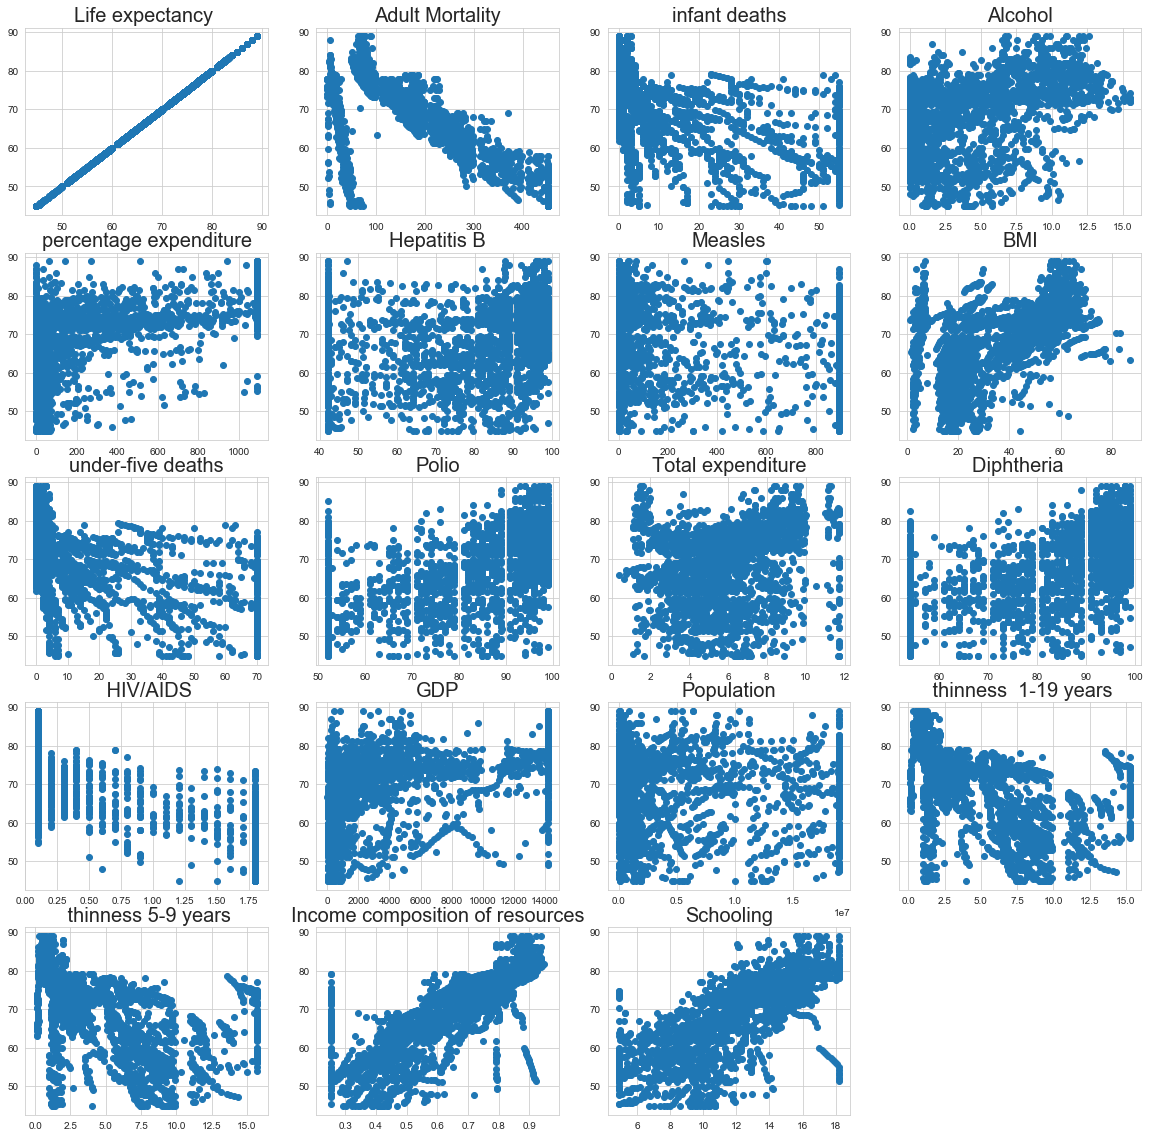

In [41]:
win_life_interp_int_df = winsorized_life_interp_df.select_dtypes(include=['float64','int'])

def get_scatterplot(df,target):
    ceil = math.ceil(math.sqrt(len(df.columns)))
    flr = math.floor(math.sqrt(len(df.columns)))
    plt.figure(figsize=(ceil*flr,ceil*flr))
    i = 1
    #print(df.columns)
    for column in df.columns[1:]: #removes "Year" column 
        plt.subplot(ceil,flr,i)
        plt.scatter(df[column],target)
        plt.title(df[column].name,fontsize=20)
        i+=1
plt.tight_layout()
plt.show() 

get_scatterplot(win_life_interp_int_df,win_life_interp_int_df["Life expectancy "])

- While some plots show a distinct relationship, it is best to calculate specific correlation values in order to build a efficient and concise model. 

In [22]:
winsorized_life_interp_df.corr()

,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
Year,1.000000,0.167962,-0.066495,-0.047331,-0.064754,0.032697,0.174527,-0.121044,0.100417,-0.052794,0.118496,0.078113,0.149467,-0.088913,0.096812,0.022316,-0.038916,-0.038693,0.199048,0.180202
Life expectancy,0.167962,1.000000,-0.690061,-0.565524,0.401751,0.489025,0.292980,-0.335783,0.557463,-0.602450,0.569655,0.217698,0.579387,-0.795478,0.486962,0.004782,-0.517968,-0.515095,0.773839,0.728470
Adult Mortality,-0.066495,-0.690061,1.000000,0.383758,-0.204278,-0.323119,-0.195807,0.210874,-0.395439,0.407828,-0.356853,-0.131571,-0.360034,0.601354,-0.316783,0.002226,0.353369,0.361505,-0.509927,-0.460372
infant deaths,-0.047331,-0.565524,0.383758,1.000000,-0.329892,-0.345100,-0.263722,0.581537,-0.448371,0.994243,-0.422830,-0.157381,-0.420737,0.415640,-0.331525,0.326512,0.442132,0.458238,-0.447874,-0.490024
Alcohol,-0.064754,0.401751,-0.204278,-0.329892,1.000000,0.388342,0.108125,-0.196007,0.319796,-0.336770,0.273060,0.298645,0.279522,-0.199028,0.435975,-0.000369,-0.439701,-0.429102,0.496410,0.526414
percentage expenditure,0.032697,0.489025,-0.323119,-0.345100,0.388342,1.000000,0.084324,-0.194434,0.327355,-0.353473,0.267522,0.178658,0.270781,-0.295663,0.679370,-0.014056,-0.333306,-0.335086,0.506357,0.497857
Hepatitis B,0.174527,0.292980,-0.195807,-0.263722,0.108125,0.084324,1.000000,-0.234983,0.201973,-0.272701,0.562620,0.104905,0.609559,-0.278200,0.130791,-0.005409,-0.149115,-0.159752,0.265892,0.261771
Measles,-0.121044,-0.335783,0.210874,0.581537,-0.196007,-0.194434,-0.234983,1.000000,-0.319776,0.579684,-0.317782,-0.158567,-0.315404,0.224990,-0.194836,0.237618,0.367060,0.371484,-0.244573,-0.308462
BMI,0.100417,0.557463,-0.395439,-0.448371,0.319796,0.327355,0.201973,-0.319776,1.000000,-0.469228,0.341747,0.228896,0.343102,-0.480885,0.332950,-0.024275,-0.557245,-0.564557,0.520761,0.515693
under-five deaths,-0.052794,-0.602450,0.407828,0.994243,-0.336770,-0.353473,-0.272701,0.579684,-0.469228,1.000000,-0.443566,-0.158223,-0.440995,0.455288,-0.343442,0.309476,0.454104,0.468466,-0.480368,-0.518747


In [23]:
winsorized_life_interp_df.corr().iloc[[1]]

,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
Life expectancy,0.167962,1.0,-0.690061,-0.565524,0.401751,0.489025,0.29298,-0.335783,0.557463,-0.60245,0.569655,0.217698,0.579387,-0.795478,0.486962,0.004782,-0.517968,-0.515095,0.773839,0.72847


Significant Positively Correlated Variables (r coefficient):
- Alcohol(.401)
- Percentage Expenditure(.489)
- BMI(.557)
- Polio(.570)
- Diptheria(.579)
- GDP(.487)
- Income Composition of Resources(.774)
- Schooling(.728)

Significant Negatively Correlated Variables (r coefficient):
- Adult Mortlaity(-.690)
- Infant Deaths(-.566)
- Under 5 Deaths(-.602)
- HIV/AIDS(-.795)
- Thinness 1-19(-.518)
- Thinness 5-9(-.515)

We would expect to see most of these varibles listed in either category. All positively correlated variables with respect to disease are a measure of immunization coverage. All negatively correlated variables with respect to disease are a measure of deaths due to that disease. 

We see how thinness and BMI run in opposition to one another as they are representations of health as well. Though we must be careful to draw to concise a comparion since the time frame of the BMI measurement is not indicated as the thinness measurement is (1-19 years, 5-9 years). 

## Developing Country vs. Developed Country 

- Becoming familiar with the data, we see that there are two types of countries present in the dataset, 'Developing' and 'Developed'. Lets take some time to investigate and see if there are significant differences in either profile.

In [44]:
developed_df = winsorized_life_interp_df[winsorized_life_interp_df['Status'] =='Developed']
developed_df.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
113,Australia,2015,Developed,82.8,59.0,1,6.305,0.000000,93.0,74,...,93.0,7.835,93.0,0.1,14223.86576,18987112.0,0.6,0.6,0.937,18.2
114,Australia,2014,Developed,82.7,6.0,1,9.710,1089.954838,91.0,340,...,92.0,9.420,92.0,0.1,14223.86576,2346694.0,0.6,0.6,0.936,18.2
115,Australia,2013,Developed,82.5,61.0,1,9.870,1089.954838,91.0,158,...,91.0,9.360,91.0,0.1,14223.86576,18987112.0,0.6,0.6,0.933,18.2
116,Australia,2012,Developed,82.3,61.0,1,10.030,1089.954838,91.0,199,...,92.0,9.360,92.0,0.1,14223.86576,18987112.0,0.6,0.6,0.930,18.2
117,Australia,2011,Developed,82.0,63.0,1,10.300,1089.954838,92.0,190,...,92.0,9.200,92.0,0.1,14223.86576,223424.0,0.6,0.6,0.927,18.2


In [46]:
developing_df = winsorized_life_interp_df[winsorized_life_interp_df['Status'] =='Developing']
developing_df.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,55,0.01,71.279624,65.0,896,...,52.0,8.16,65.0,0.1,584.259210,18987112.0,15.3,15.7,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,55,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,15.3,15.7,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,55,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,18987112.0,15.3,15.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,55,0.01,78.184215,67.0,896,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,15.3,15.7,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,55,0.01,7.097109,68.0,896,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,15.3,15.7,0.454,9.5


In [47]:
dvlped_corr_df = developed_df.corr().iloc[[1]].T
dvlped_corr_df.columns = dvlped_corr_df.columns.str.replace('Life expectancy','Developed')
#dvlped_corr_df

In [48]:
dvlping_corr_df = developing_df.corr().iloc[[1]].T
dvlping_corr_df.columns = dvlping_corr_df.columns.str.replace('Life expectancy','Developing')
#dvlping_corr_df

In [49]:
corr_df = dvlping_corr_df.join(dvlped_corr_df)
#df['Score_diff'] = df['Developing'].sub(df['Developed'], axis = 0) 
corr_df

,Developing,Developed
Year,0.185726,3.327253e-01
Life expectancy,1.000000,1.000000e+00
Adult Mortality,-0.648917,-4.854888e-01
infant deaths,-0.518782,-5.476379e-02
Alcohol,0.206278,-2.734338e-01
percentage expenditure,0.404388,2.764920e-01
Hepatitis B,0.333950,-2.380480e-01
Measles,-0.347796,1.814137e-01
BMI,0.542945,-4.396246e-02
under-five deaths,-0.562523,-4.795308e-02


-  The 'Life Expectancy' correlation matrix shows us some key areas where the 'Developed' and 'Developing' categories differ. We see the most distinct differences in the 'Infant Deaths', 'BMI', 'Under 5 Deaths', 'Polio', 'Diptheria', and 'HIV/AIDS' variables. We would expect to see these result given all of these variables are inherently tied to the profile of a nation that has a robust healthcare system.  

In [50]:
developing_df.groupby("Country").mean().describe()

,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
count,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,1.610000e+02,161.000000,161.000000,161.000000,161.000000
mean,2007.841615,67.071778,177.452640,15.254270,3.333752,203.686503,80.318473,239.414208,37.152057,20.130823,83.822732,5.677454,84.026342,0.586995,3428.194442,5.186597e+06,5.215848,5.252975,0.601664,11.354904
std,1.331614,8.371115,88.518945,19.723369,3.024794,231.312464,14.088296,268.645616,17.845184,25.962798,13.126694,1.721715,12.707352,0.676543,3422.975895,5.231446e+06,3.654004,3.721327,0.152744,2.760305
min,2007.500000,47.200000,16.500000,0.000000,0.010000,0.000000,42.000000,0.000000,5.200000,0.000000,52.000000,1.856250,54.000000,0.100000,136.183210,2.920000e+02,0.100000,0.100000,0.255000,4.900000
25%,2007.500000,60.862500,116.187500,0.500000,0.746875,21.961645,70.375000,2.000000,19.431250,0.750000,74.750000,4.614063,75.312500,0.100000,781.016004,6.969116e+05,2.212500,2.337500,0.473062,9.825000
50%,2007.500000,69.193750,159.937500,4.000000,2.479375,98.838448,82.187500,128.250000,38.425000,5.687500,86.937500,5.669687,86.562500,0.125000,2165.090838,3.313384e+06,4.956250,4.850000,0.627063,11.893750
75%,2007.500000,73.618750,238.500000,26.562500,5.205000,344.690631,93.875000,410.000000,50.156250,36.625000,95.500000,6.638438,95.625000,1.181250,4781.216822,9.288266e+06,7.437500,7.368750,0.721000,13.181250
max,2013.000000,82.218750,427.000000,55.000000,13.157812,918.734573,99.000000,896.000000,87.300000,70.000000,99.000000,11.710000,99.000000,1.800000,14223.865760,1.898711e+07,15.300000,15.700000,0.901316,17.839541


In [51]:
developed_df.groupby("Country").mean().describe()

,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
count,32.0,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,3.200000e+01,32.000000,3.200000e+01,32.000000,32.000000,32.000000,32.000000
mean,2007.5,79.197852,79.685547,1.494141,9.634141,638.653197,85.228304,131.843750,51.803906,1.810547,94.324219,7.396288,94.355469,1.000000e-01,9526.953875,4.762800e+06,1.320703,1.296680,0.847715,15.537492
std,0.0,3.223014,31.242662,4.631272,2.333306,307.669789,15.043228,180.192351,7.890487,5.436410,3.558357,1.593463,3.954773,4.229954e-17,2318.934705,4.514154e+06,0.754457,0.827088,0.048786,1.522703
min,2007.5,72.806250,49.375000,0.000000,1.762500,0.000000,42.000000,0.000000,25.606250,0.000000,86.000000,4.037188,81.875000,1.000000e-01,4258.940054,9.738406e+04,0.300000,0.218750,0.754625,12.441837
25%,2007.5,76.606250,60.359375,0.000000,8.404375,465.088499,80.546875,6.250000,51.029688,0.000000,92.203125,6.317187,92.656250,1.000000e-01,8258.578357,1.170865e+06,0.745312,0.620312,0.804828,14.225000
50%,2007.5,80.521875,66.906250,0.000000,9.948438,739.684120,91.914773,62.343750,52.759375,0.000000,95.281250,7.402969,95.000000,1.000000e-01,9595.344779,3.510850e+06,1.071875,0.981250,0.859250,15.481250
75%,2007.5,81.559375,79.578125,1.156250,11.201172,864.383627,95.125000,145.437500,55.834375,1.500000,96.765625,8.556574,97.078125,1.000000e-01,11044.725440,8.101348e+06,1.839063,1.918750,0.891266,16.621875
max,2007.5,82.537500,161.812500,26.187500,12.906875,1006.352784,99.000000,655.000000,66.181250,30.750000,98.937500,11.596250,99.000000,1.000000e-01,13307.533001,1.898711e+07,3.168750,3.506250,0.931437,18.200000


- Across the data, we consistently recognize distinct differneces between the 'Developing' and 'Developed' categories. The average life expectancy in developed countries is 79.12, with an average standard deviation of 3.22, in developing countries the average life expectancy is 67.07, with an average standard deviation of 8.37. The data shows much more variabililty in the developing countries.

In [52]:
from scipy.stats import ttest_ind
print(ttest_ind(developing_df['Life expectancy '], developed_df['Life expectancy '], equal_var=False))

Ttest_indResult(statistic=-48.02945958907459, pvalue=0.0)


- A t-test of the 'Life Expectancy' variable in either country category determines that the correlation differences are so great, the model analysis will continue to address the two categories separately.

## Correlation analysis

- To select the most influential and unique indicators for our models, we take a look again at a correlation matrix for each country category.

In [53]:
developing_df.corr()

,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
Year,1.000000,0.185726,-0.066989,-0.053386,-0.053045,0.083150,0.195432,-0.145301,0.107901,-0.060018,0.129473,0.077679,0.161778,-0.102855,0.123242,0.011032,-0.044264,-0.043620,0.236873,0.212882
Life expectancy,0.185726,1.000000,-0.648917,-0.518782,0.206278,0.404388,0.333950,-0.347796,0.542945,-0.562523,0.542486,0.096326,0.555973,-0.797813,0.387168,0.016425,-0.405503,-0.401265,0.700980,0.658151
Adult Mortality,-0.066989,-0.648917,1.000000,0.327116,-0.027418,-0.244905,-0.207242,0.198134,-0.358554,0.353168,-0.307721,-0.030273,-0.310742,0.569621,-0.219619,-0.005712,0.255538,0.264609,-0.421884,-0.371908
infant deaths,-0.053386,-0.518782,0.327116,1.000000,-0.219456,-0.291290,-0.271787,0.600993,-0.429300,0.993731,-0.379417,-0.106309,-0.381723,0.363540,-0.275033,0.349013,0.376168,0.395170,-0.365061,-0.427952
Alcohol,-0.053045,0.206278,-0.027418,-0.219456,1.000000,0.235208,0.063066,-0.167175,0.188559,-0.227183,0.167860,0.199351,0.172350,-0.040196,0.295770,0.029641,-0.302296,-0.288114,0.317624,0.378951
percentage expenditure,0.083150,0.404388,-0.244905,-0.291290,0.235208,1.000000,0.143121,-0.214677,0.323441,-0.303377,0.224572,0.094305,0.242066,-0.240745,0.615582,0.031362,-0.229161,-0.231318,0.412195,0.396420
Hepatitis B,0.195432,0.333950,-0.207242,-0.271787,0.063066,0.143121,1.000000,-0.253382,0.206859,-0.281784,0.611832,0.090334,0.666914,-0.285809,0.161032,0.005522,-0.140618,-0.155151,0.299962,0.302937
Measles,-0.145301,-0.347796,0.198134,0.600993,-0.167175,-0.214677,-0.253382,1.000000,-0.338182,0.598611,-0.316073,-0.142585,-0.313990,0.206810,-0.187305,0.220438,0.367667,0.373726,-0.223701,-0.302425
BMI,0.107901,0.542945,-0.358554,-0.429300,0.188559,0.323441,0.206859,-0.338182,1.000000,-0.452725,0.306758,0.157646,0.307471,-0.463908,0.290131,-0.041138,-0.534656,-0.544828,0.485481,0.482190
under-five deaths,-0.060018,-0.562523,0.353168,0.993731,-0.227183,-0.303377,-0.281784,0.598611,-0.452725,1.000000,-0.401951,-0.104406,-0.403358,0.406127,-0.288477,0.331047,0.388489,0.405473,-0.403987,-0.462661


In [54]:
def get_interaction_corr(corr, threshold):
    col_headers = corr.index.values
    for row in range(len(corr)):
        for col in range(row):
            if (corr.iloc[row, col] > threshold) or (corr.iloc[row, col] < -threshold):
                print("{}, {}: corr. = {}".format(col_headers[row], col_headers[col], corr.iloc[row, col]))
                
get_interaction_corr(developing_df.corr(),.85)              

under-five deaths, infant deaths: corr. = 0.9937307683040152
Diphtheria , Polio: corr. = 0.854536288672292
 thinness 5-9 years,  thinness  1-19 years: corr. = 0.9320803847487087


We see from the Developing Country correlation matrix, there are a fair amount of relevant indicators that would be well suited for a life expectancy model. Also of note, the correlation between the 'Under 5 Deaths' variable and the 'Infant Death' variable, at a value of .994. Working towards a clean model, since these variables are so correlated, the 'Infant Deaths' variable is left out due to its lesser correlation magnitude with respect to Life Expectancy.
The indicators of the Developing Country Life Expectancy Model are as follows: 
- Adult Mortality(-.649) 
- BMI(.543)
- Under 5 Deaths(-.562)
- Polio(.542) 
- Diptheria(.556)
- HIV/AIDS(-.798)
- Income Composition of Resources(.701)
- Schooling(.658)

<Figure size 432x288 with 0 Axes>

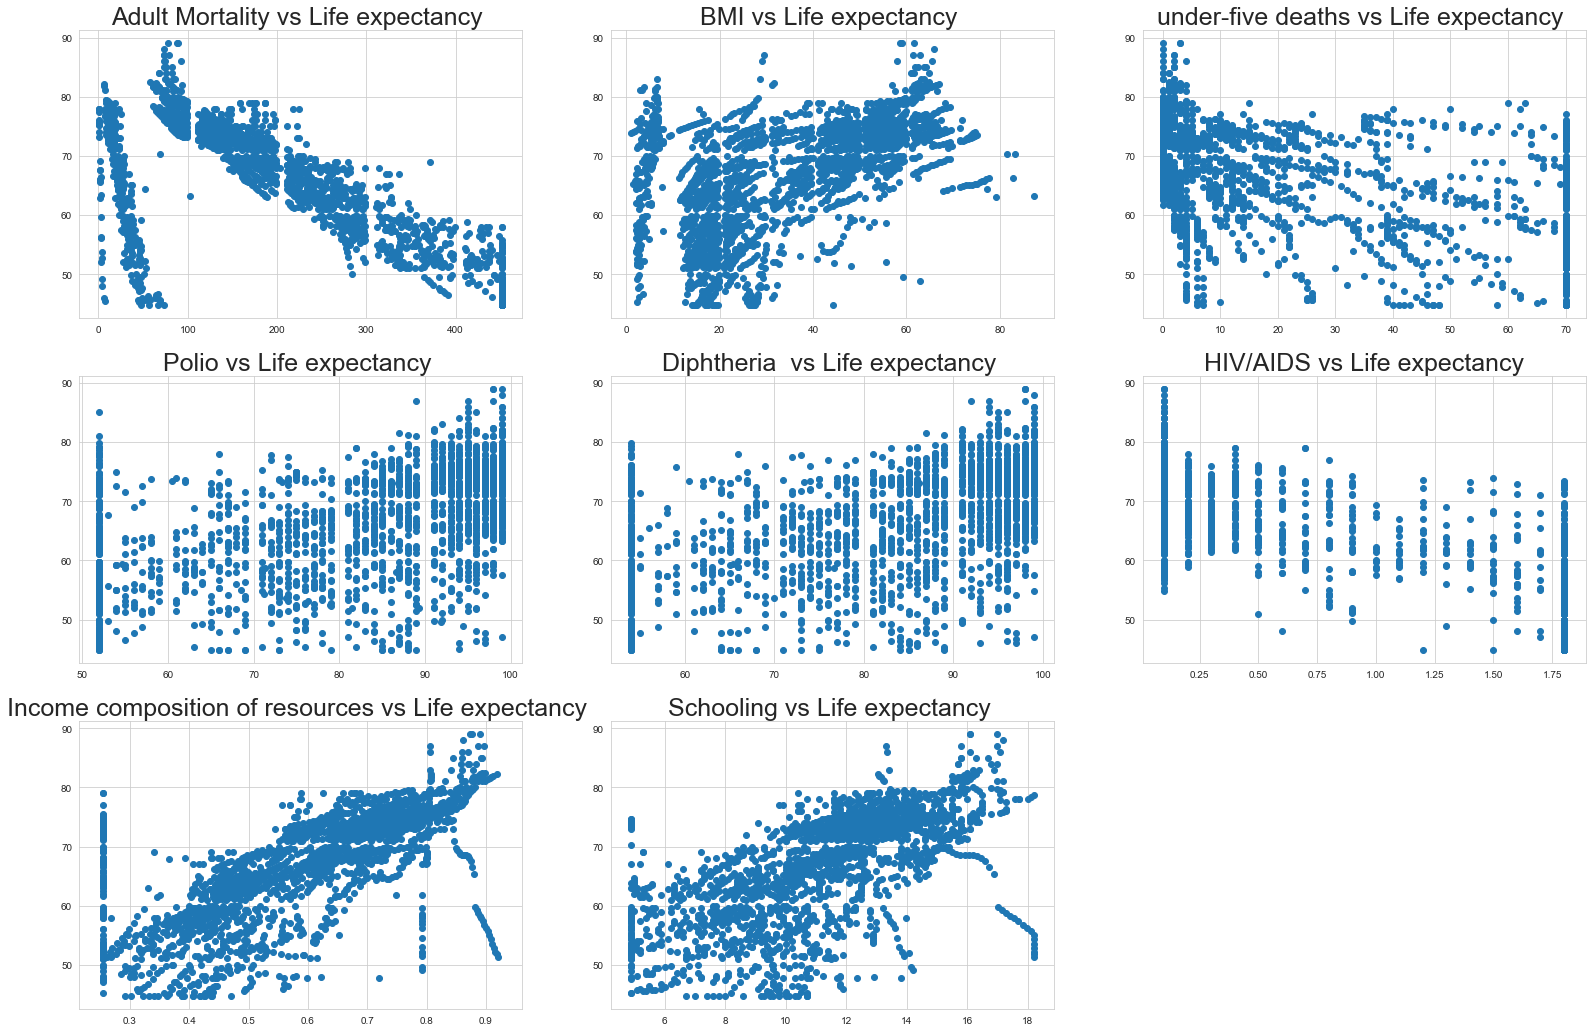

In [74]:
developing_high_corr_df = developing_df[['Life expectancy ','Adult Mortality','BMI','under-five deaths','Polio',
                                         'Diphtheria ',' HIV/AIDS','Income composition of resources','Schooling']]

def get_scatterplot(df,target):
    ceil = math.ceil(math.sqrt(len(df.columns)))
    flr = math.floor(math.sqrt(len(df.columns)))
    plt.figure(figsize=(3*ceil*flr,2*ceil*flr))
    i = 1
    #print(df.columns)
    for column in df.columns[1:]: #removes "Year" column 
        plt.subplot(ceil,flr,i)
        plt.scatter(df[column],target)
        plt.title("{} vs {}".format(df[column].name,target.name),fontsize=25)
        i+=1
plt.tight_layout()
plt.show() 

get_scatterplot(developing_high_corr_df,developing_high_corr_df["Life expectancy "])

In [35]:
developed_df.corr()

,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
Year,1.000000,3.327253e-01,-0.146058,-0.041294,-2.157496e-01,-1.106712e-01,7.747403e-02,0.025930,9.801876e-02,-0.038874,0.101650,1.013865e-01,0.140095,0.000000e+00,5.579425e-02,8.278380e-02,-8.627021e-02,-8.923587e-02,3.433494e-01,2.116185e-01
Life expectancy,0.332725,1.000000e+00,-0.485489,-0.054764,-2.734338e-01,2.764920e-01,-2.380480e-01,0.181414,-4.396246e-02,-0.047953,0.000515,8.902721e-02,-0.038012,-9.392974e-15,1.413747e-01,1.232637e-01,-5.880775e-01,-5.965299e-01,6.822831e-01,3.458906e-01
Adult Mortality,-0.146058,-4.854888e-01,1.000000,-0.048109,1.279694e-01,-1.594442e-01,1.778734e-01,-0.112609,-1.024146e-02,-0.048614,0.033531,-1.486820e-01,0.020865,0.000000e+00,-1.409193e-01,-5.975996e-02,4.716446e-01,4.805526e-01,-4.137095e-01,-1.812818e-01
infant deaths,-0.041294,-5.476379e-02,-0.048109,1.000000,-6.907731e-02,-2.683330e-01,2.489090e-02,0.122362,4.750158e-02,0.997815,-0.182492,2.573676e-01,0.032525,0.000000e+00,8.793404e-02,2.446390e-01,-1.070207e-01,-1.194428e-01,-2.317799e-01,-1.235608e-01
Alcohol,-0.215750,-2.734338e-01,0.127969,-0.069077,1.000000e+00,5.467133e-02,5.115562e-02,-0.003664,1.210771e-01,-0.067928,-0.035782,1.717987e-02,-0.015678,-4.703109e-15,-2.103440e-03,-1.064703e-02,6.761809e-03,2.865684e-02,-2.189772e-01,-8.950401e-02
percentage expenditure,-0.110671,2.764920e-01,-0.159444,-0.268333,5.467133e-02,1.000000e+00,-2.761627e-01,0.087846,-9.736761e-02,-0.268691,-0.050789,-1.616429e-02,-0.152454,4.507664e-15,5.849415e-01,-1.142388e-01,-2.120563e-01,-2.083866e-01,4.197540e-01,3.330003e-01
Hepatitis B,0.077474,-2.380480e-01,0.177873,0.024891,5.115562e-02,-2.761627e-01,1.000000e+00,-0.033189,3.484939e-02,0.028461,0.109554,3.788020e-02,0.123563,-6.280600e-16,-1.657176e-01,-4.449716e-02,2.437247e-01,2.662938e-01,-3.571880e-01,-2.248461e-01
Measles,0.025930,1.814137e-01,-0.112609,0.122362,-3.664360e-03,8.784643e-02,-3.318851e-02,1.000000,1.845476e-02,0.129422,-0.001315,-5.678193e-02,-0.006205,0.000000e+00,1.827016e-02,3.549730e-01,-1.022618e-01,-1.183658e-01,6.506758e-02,-5.128481e-02
BMI,0.098019,-4.396246e-02,-0.010241,0.047502,1.210771e-01,-9.736761e-02,3.484939e-02,0.018455,1.000000e+00,0.043874,0.053515,1.330829e-01,0.056487,-1.260146e-16,-3.738055e-02,1.463834e-01,-1.307655e-01,-1.025510e-01,-3.977466e-02,5.794537e-02
under-five deaths,-0.038874,-4.795308e-02,-0.048614,0.997815,-6.792757e-02,-2.686908e-01,2.846090e-02,0.129422,4.387390e-02,1.000000,-0.179348,2.527817e-01,0.035299,0.000000e+00,8.184299e-02,2.335664e-01,-1.072737e-01,-1.204372e-01,-2.254468e-01,-1.195161e-01


In [36]:
def get_interaction_corr(corr, threshold):
    col_headers = corr.index.values
    for row in range(len(corr)):
        for col in range(row):
            if (corr.iloc[row, col] > threshold) or (corr.iloc[row, col] < -threshold):
                print("{}, {}: corr. = {}".format(col_headers[row], col_headers[col], corr.iloc[row, col]))
                
get_interaction_corr(developed_df.corr(),.85)

under-five deaths, infant deaths: corr. = 0.9978145371182174
 thinness 5-9 years,  thinness  1-19 years: corr. = 0.9904428401150926


From the Devolped Country correlation matrix, we do not see as many significantly correlated variables as the Developing matrix. However we do see that there is significant correlation between te 'Thiness 1-19' variable and the 'Thinness 5-9' variable. To keep a clean model, the 'Thinness 5-9' vaible is selected. 
The indicators of the Developed Country Life expectancy Model are as follows:

- Adult Mortality(-.485)
- Thinness 5-9(-.596)
- Income Composition of Resources(.682)

In [76]:
developed_df.columns

Index(['Country', 'Year', 'Status', 'Life expectancy ', 'Adult Mortality',
       'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B',
       'Measles', 'BMI', 'under-five deaths', 'Polio', 'Total expenditure',
       'Diphtheria ', ' HIV/AIDS', 'GDP', 'Population',
       ' thinness  1-19 years', ' thinness 5-9 years',
       'Income composition of resources', 'Schooling'],
      dtype='object')

<Figure size 432x288 with 0 Axes>

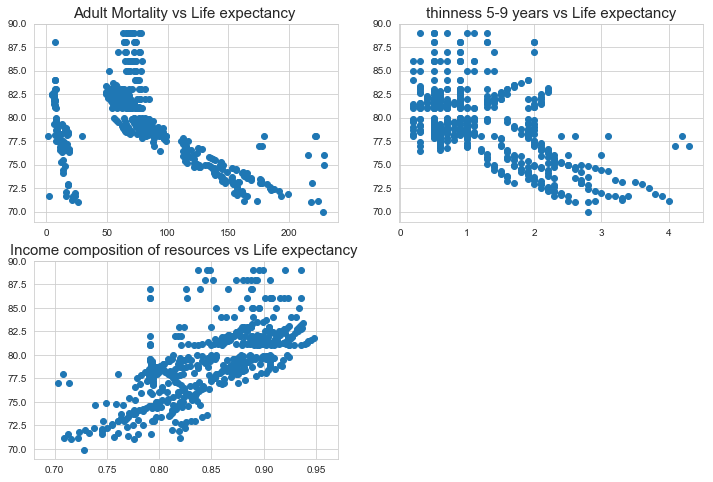

In [79]:
developed_high_corr_df = developed_df[['Life expectancy ','Adult Mortality',' thinness 5-9 years',
                                       'Income composition of resources']]

def get_scatterplot(df,target):
    ceil = math.ceil(math.sqrt(len(df.columns)))
    flr = math.floor(math.sqrt(len(df.columns)))
    plt.figure(figsize=(3*ceil*flr,2*ceil*flr))
    i = 1
    #print(df.columns)
    for column in df.columns[1:]: #removes "Year" column 
        plt.subplot(ceil,flr,i)
        plt.scatter(df[column],target)
        plt.title("{} vs {}".format(df[column].name,target.name),fontsize=15)
        i+=1
plt.tight_layout()
plt.show() 

get_scatterplot(developed_high_corr_df,developed_high_corr_df["Life expectancy "])

## Analysis Summary 

This analysis has separated the dataset into two groups, such that we conclude two effective sets of indicators. Group one contains all countries found under the 'Developing' status, group two contains all countries unfer the 'Developed' status. It was found that the profiles of life expectancy in each group were statistically divergent. This course of action leads to a much higher degree of model relevance with respect to each group.  

After cleaning the data, accounting for missing information with the interpolation method and treating each variable category's outliers through the Winsor method, both group's variable are assessed for their correlation coefficient to the target variable 'Life Expectancy' as well as correlation to the other variables. In this way, eight varibles were chosen to serve as indicators for the 'Developing Country' model; Adult Mortality, BMI, Under 5 Deaths, Polio, Diptheria, HIV/AIDS, Income Composition of Resources, Scooling. Three variable categories were chosen by these methods to serve as indicators for the 'Developed Country' model; Adult Mortality, Thinness 5-9, Income Composition of Resources.